# Interactive Plots

With special plotting libraries like `holoviews` and `datashader` for
big data visualization as well as `bokeh` for interactiveness, we can
use the functionality of pyOpenMS to quickly create fully interactive
views of mass spectrometry data. Here we plot a full map of
[MS1](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-MS1)
that can be interactively zoomed-in if you execute the code in a
notebook (e.g. on Binder, see the button on top of the page).

In [ ]:
import pyopenms as oms
import pandas as pd
import numpy as np
import datashader as ds
import holoviews as hv
import holoviews.operation.datashader as hd
from holoviews.plotting.util import process_cmap
from holoviews import opts, dim

hv.extension("bokeh")

exp = oms.MSExperiment()  # type: PeakMap
loader = oms.MzMLFile()
loadopts = loader.getOptions()  # type: PeakFileOptions
loadopts.setMSLevels([1])
loadopts.setSkipXMLChecks(True)
loadopts.setIntensity32Bit(True)
loader.setOptions(loadopts)
loader.load("../../../src/data/BSA1.mzML", exp)

# Filter out low-intensity peaks using ThresholdMower
threshold_filter = oms.ThresholdMower()
params = threshold_filter.getDefaults()
params.setValue(b"threshold", 5000.0)
threshold_filter.setParameters(params)
threshold_filter.filterPeakMap(exp)

exp.updateRanges()
expandcols = ["RT", "mz", "inty"]
spectraarrs2d = exp.get2DPeakDataLong(
    exp.getMinRT(), exp.getMaxRT(), exp.getMinMZ(), exp.getMaxMZ(), 1
)
spectradf = pd.DataFrame(dict(zip(expandcols, spectraarrs2d)))
spectradf = spectradf.set_index(["RT", "mz"])

maxrt = spectradf.index.get_level_values(0).max()
minrt = spectradf.index.get_level_values(0).min()
maxmz = spectradf.index.get_level_values(1).max()
minmz = spectradf.index.get_level_values(1).min()


def new_bounds_hook(plot, elem):
    x_range = plot.state.x_range
    y_range = plot.state.y_range
    x_range.bounds = minrt, maxrt
    y_range.bounds = minmz, maxmz


points = hv.Points(
    spectradf, kdims=["RT", "mz"], vdims=["inty"], label="MS1 survey scans"
).opts(
    fontsize={"title": 16, "labels": 14, "xticks": 6, "yticks": 12},
    color=np.log(dim("int")),
    colorbar=True,
    cmap="Magma",
    width=1000,
    height=1000,
    tools=["hover"],
)

raster = (
    hd.rasterize(
        points,
        cmap=process_cmap("blues", provider="bokeh"),
        aggregator=ds.sum("inty"),
        cnorm="log",
        alpha=10,
        min_alpha=0,
    )
    .opts(active_tools=["box_zoom"], tools=["hover"], hooks=[new_bounds_hook])
)

hd.dynspread(raster, threshold=0.7, how="add", shape="square").opts(
    width=800,
    height=800,
    xlabel="Retention time (s)",
    ylabel="mass/charge (Da)",
)

Result:

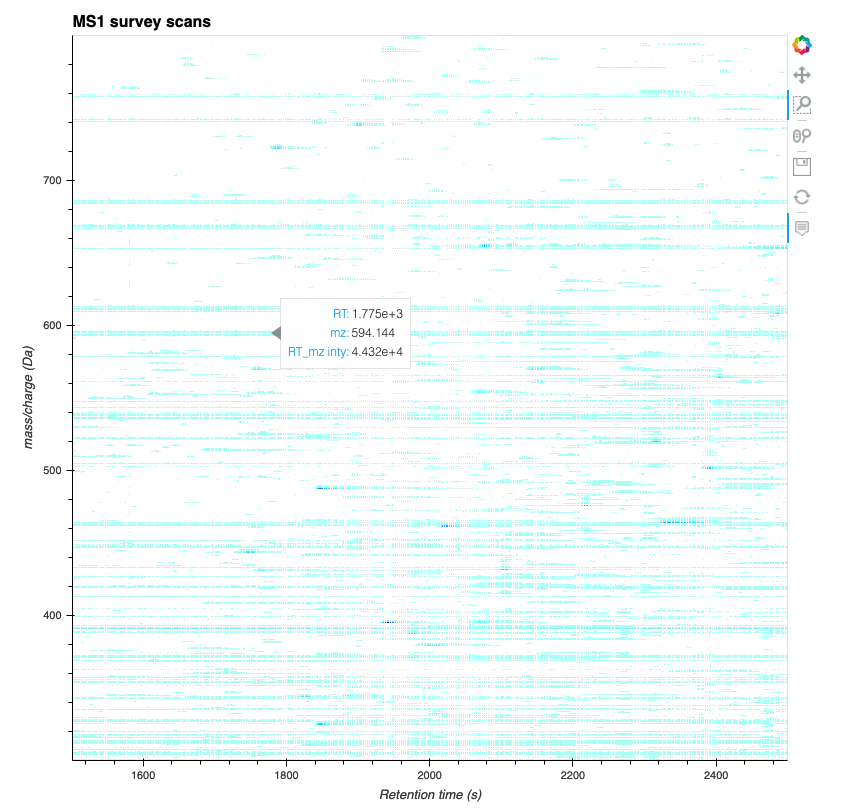

With this you can also easily create whole dashboards like the one
hosted
[here](https://notebooks.gesis.org/binder/v2/gh/OpenMS/pyopenms-docs/master+ipynb?urlpath=msbokehapps)
on a Binder instance. If you are reading/executing this on Binder
already, execute the next cell to get a link to your current instance.

In [ ]:
import os
from IPython.display import Markdown as md

md(
    "When you are in binder already, you can quickly open the app [here]({}/msbokehapps).".format(
        os.getenv("JUPYTERHUB_SERVICE_PREFIX")
    )
)